In [2]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MultipleLocator
from datetime import datetime, timedelta

In [2]:
# Configure plots
rc('font',weight='normal',size=20,family='serif',serif='Computer Modern Roman')
rc('text',usetex='True')

In [3]:
class simulation():
    """Contains simulation parameters and can read averaged csv files
    
    :var dict xytavg: averages of instantaneous variables in x,y,t dimensions
    :var dict cov: covariances of instantaneous variables averaged in x,y,t dimensions
    :var dict most: monin-obukhov similarity parameters
    """
    def __init__(self, path, nx, ny, nz, Lx, Ly, Lz):
        """Creates a simulation object with appropriate setup parameters
        :param string path: absolute path to simulation output directory
        :param int nx: number of grid points in x-dimension
        :param int ny: number of grid points in y-dimension
        :param int nz: number of grid points in z-dimension
        :param float Lx: physical length of x-dimension in meters
        :param float Ly: physical length of y-dimension in meters
        :param float Lz: physical length of z-dimension in meters
        """
        # initialize with args
        self.path = path
        self.nx = nx
        self.ny = ny
        self.nz = nz
        self.Lx = Lx
        self.Ly = Ly
        self.Lz = Lz
        
        # calculate dx, dy, dz, nt
        self.dx = self.Lx/float(self.nx)
        self.dy = self.Ly/float(self.ny)
        self.dz = self.Lz/float(self.nz-1)
        
        # create label
        self.lab = str(self.nx).zfill(3)
        
        # initialize empty dicts for averaged and covariance vars
        self.xytavg = {}
        self.cov = {}
        self.var = {}
        self.Ri = {}
        self.most = {}
        
        # initialize empty z variable
        self.z = None
        self.zi = None
        
    def read_csv(self):
        print(f"Beginning loading data for {self.nx}^3 simulation--")
        print(f"Reading file: {self.path}")
        
        data = np.genfromtxt(self.path, dtype=float, delimiter=",", skip_header=1)
        # assign each column to parameters
        # columns are:
        # z, ubar, vbar, wbar, Tbar, uw_cov_res, uw_cov_tot,
        # vw_cov_res, vw_cov_tot, thetaw_cov_res, thetaw_cov_tot,
        # u_var_res, u_var_tot, v_var_res, v_var_tot, w_var_res,
        # w_var_tot, theta_var_res
#         self.z = data[:, 0]
        self.z = np.linspace(0., 400., self.nz)
        self.xytavg["u"] = data[:, 1]
        self.xytavg["v"] = data[:, 2]
        self.xytavg["w"] = data[:, 3]
        self.xytavg["theta"] = data[:, 4]
        self.xytavg["dissip"] = data[:, 5]
        self.cov["uw_cov_res"] = data[:, 6]
        self.cov["uw_cov_tot"] = data[:, 7]
        self.cov["vw_cov_res"] = data[:, 8]
        self.cov["vw_cov_tot"] = data[:, 9]
        self.cov["thetaw_cov_res"] = data[:, 10]
        self.cov["thetaw_cov_tot"] = data[:, 11]
        self.var["u_var_res"] = data[:, 12]
        self.var["u_var_tot"] = data[:, 13]
        self.var["v_var_res"] = data[:, 14]
        self.var["v_var_tot"] = data[:, 15]
        self.var["w_var_res"] = data[:, 16]
        self.var["w_var_tot"] = data[:, 17]
        self.var["theta_var_tot"] = data[:, 18]
        
        # calculate ustar and thetastar and assign to cov
        ustar = ((self.cov["uw_cov_tot"]**2.) + (self.cov["vw_cov_tot"]**2.)) ** 0.25
        self.cov["ustar"] = ustar
        thetastar = -self.cov["thetaw_cov_tot"] / ustar
        self.cov["thetastar"] = thetastar
        L = -(ustar ** 3.) * self.xytavg["theta"][0] / (0.4 * 9.81 * self.cov["thetaw_cov_tot"])
        self.cov["L"] = L
    
        # calculate TKE and assign to var
        TKE = 0.5 * (self.var["u_var_tot"] + self.var["v_var_tot"] + self.var["w_var_tot"])
        self.var["TKE_tot"] = TKE
        u_var_sgs = self.var["u_var_tot"] - self.var["u_var_res"]
        v_var_sgs = self.var["v_var_tot"] - self.var["v_var_res"]
        w_var_sgs = self.var["w_var_tot"] - self.var["w_var_res"]
        TKE_sgs = 0.5 * (u_var_sgs + v_var_sgs + w_var_sgs)
        self.var["TKE_sgs"] = TKE_sgs
        
        # calculate zi based on linear extrapolated method
        i_zi = np.where(ustar <= 0.05*ustar[0])[0][0]
        self.zi = self.z[i_zi] / 0.95
        
        # calculate ws and wd and assign to xytavg
        self.xytavg["ws"] = np.sqrt( self.xytavg["u"]**2. + self.xytavg["v"]**2. )
        self.xytavg["wd"] = np.arctan2(-self.xytavg["u"], -self.xytavg["v"]) * 180./np.pi
        self.xytavg["wd"][self.xytavg["wd"] < 0.] += 360.
        
        # calculate level of LLJ core using wspd
        self.xytavg["zj"] = self.z[np.argmax(self.xytavg["ws"])]
        
        return
    
    def calc_Ri(self):
        du_dz, dv_dz, dtheta_dz, dws_dz = ([] for _ in range(4))
        ws = ( (self.xytavg["u"]**2.) + (self.xytavg["v"]**2.) ) ** 0.5
        
        for i in range(1, self.nz-1):
            du_dz.append( (self.xytavg["u"][i+1] - self.xytavg["u"][i-1]) / (2.*self.dz) )
            dv_dz.append( (self.xytavg["v"][i+1] - self.xytavg["v"][i-1]) / (2.*self.dz) )
            dtheta_dz.append( (self.xytavg["theta"][i+1] - self.xytavg["theta"][i-1]) / (2.*self.dz) )
            dws_dz.append( (ws[i+1] - ws[i-1]) / (2.*self.dz) )
        du_dz = np.array(du_dz)
        dv_dz = np.array(dv_dz)
        dtheta_dz = np.array(dtheta_dz)
        dws_dz = np.array(dws_dz)
        
        S2 =(du_dz**2.) + (dv_dz**2.)
#         S2 = dws_dz ** 2.
        N2 = dtheta_dz * 9.81 / self.xytavg["theta"][0]
        Ri = N2 / S2
        
        self.Ri["du_dz"] = du_dz
        self.Ri["dv_dz"] = dv_dz
        self.Ri["dtheta_dz"] = dtheta_dz
        self.Ri["S2"] = S2
        self.Ri["N2"] = N2
        self.Ri["Ri"] = Ri
        
        # now calculate flux Ri
        Ri_f_num = self.cov["thetaw_cov_tot"][1:-1] * 9.81 / self.xytavg["theta"][0]
        Ri_f_den = (self.cov["uw_cov_tot"][1:-1] * du_dz) + (self.cov["vw_cov_tot"][1:-1] * dv_dz)
        self.Ri["Ri_f"] = Ri_f_num / Ri_f_den
        
        # calculate zB from van de Wiel et al 2008
        # zB = sqrt(0.5) * sigma_w/N = sqrt(0.5 * var_w / N2)
        self.Ri["zB"] = (0.5 * self.var["w_var_tot"][1:-1] / N2) ** 0.5
        
        # calculate Ozmidov scale Lo
        # Lo = sqrt[<dissipation>/(N^2)^3/2]
        self.Ri["Lo"] = np.sqrt(-self.xytavg["dissip"][1:-1] / (N2 ** (3./2.)))
        
        return
    
    def calc_most(self):
        k = 0.4
        phi_m = np.sqrt(self.Ri["S2"]) * k * self.z[1:-1] / self.cov["ustar"][0]
        phi_h = self.Ri["dtheta_dz"] * k * self.z[1:-1] / self.cov["thetastar"][0]
        phi_m_MO = 1. + 6.*self.z/self.cov["L"][0]
        phi_h_MO = 0.95 + 7.8*self.z/self.cov["L"][0]
        # calculate local phi_m, phi_h
        phi_m_l = np.sqrt(self.Ri["S2"]) * k * self.z[1:-1] / self.cov["ustar"][1:-1]
        phi_h_l = self.Ri["dtheta_dz"] * k * self.z[1:-1] / self.cov["thetastar"][1:-1]
        
        # assign
        self.most["phi_m"] = phi_m
        self.most["phi_h"] = phi_h      
        self.most["phi_m_MO"] = phi_m_MO
        self.most["phi_h_MO"] = phi_h_MO
        self.most["phi_m_l"] = phi_m_l
        self.most["phi_h_l"] = phi_h_l
        
        # now look at gradient-based scales
        Us = k * self.z[1:-1] * np.sqrt(self.Ri["N2"])
        Ts = k * self.z[1:-1] * self.Ri["dtheta_dz"]
        Ls = k * self.z[1:-1]
        # assign
        self.most["Gm"] = (self.cov["ustar"][1:-1]**2.) / (Us**2.)
        self.most["Gh"] = -self.cov["thetaw_cov_tot"][1:-1] / Us / Ts
        self.most["Gw"] = np.sqrt(self.var["w_var_tot"][1:-1]) / Us
        self.most["Gtheta"] = np.sqrt(self.var["theta_var_tot"][1:-1]) / Ts
        self.most["Us"] = Us
        self.most["Ts"] = Ts
        self.most["Ls"] = Ls
        
        return

In [4]:
s096 = simulation("/home/bgreene/simulations/C_spinup/output/average_statistics_v2.csv",
                  96, 96, 96, 800., 800., 400.)
s128 = simulation("/home/bgreene/simulations/C_128_interp/output/average_statistics_v2.csv",
                  128, 128, 128, 800., 800., 400.)
s160 = simulation("/home/bgreene/simulations/C_160_interp/output/average_statistics_v2.csv",
                  160, 160, 160, 800., 800., 400.)
s192 = simulation("/home/bgreene/simulations/C_192_interp/output/average_statistics_v2.csv",
                  192, 192, 192, 800., 800., 400.)
s256a = simulation("/home/bgreene/simulations/C_256_interp/output/average_statistics_v2.csv",
                  256, 256, 256, 800., 800., 400.) # 2nd hour after interp
# s256b = simulation("/home/bgreene/simulations/C_256_interp/output/average_statistics_3.csv",
#                   256, 256, 256, 800., 800., 400.) # 1st hour after interp
# s256c = simulation("",256, 256, 256, 800., 800., 400.)
s128A = simulation("/home/bgreene/simulations/A_128_interp/output/average_statistics.csv",
                  128, 128, 128, 800., 800., 400.)
s128A2 = simulation("/home/bgreene/simulations/A_128_interp/output/average_statistics_2hr.csv",
                  128, 128, 128, 800., 800., 400.)
s128A3 = simulation("/home/bgreene/simulations/A_128_interp/output/average_statistics_3hr.csv",
                  128, 128, 128, 800., 800., 400.)
s160A = simulation("/home/bgreene/simulations/A_160_interp/output/average_statistics.csv",
                  160, 160, 160, 800., 800., 400.)
s192A = simulation("/home/bgreene/simulations/A_192_interp/output/average_statistics.csv",
                  192, 192, 192, 800., 800., 400.)

In [30]:
# s_all = [s096, s128, s160, s192, s256a]
s_all = [s096, s128, s160, s192]
# s_all = [s128A, s160A, s192A]
for s in s_all:
    s.read_csv()
    s.calc_Ri()
    s.calc_most()

Beginning loading data for 96^3 simulation--
Reading file: /home/bgreene/simulations/C_spinup/output/average_statistics_v2.csv
Beginning loading data for 128^3 simulation--
Reading file: /home/bgreene/simulations/C_128_interp/output/average_statistics_v2.csv
Beginning loading data for 160^3 simulation--
Reading file: /home/bgreene/simulations/C_160_interp/output/average_statistics_v2.csv
Beginning loading data for 192^3 simulation--
Reading file: /home/bgreene/simulations/C_192_interp/output/average_statistics_v2.csv


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


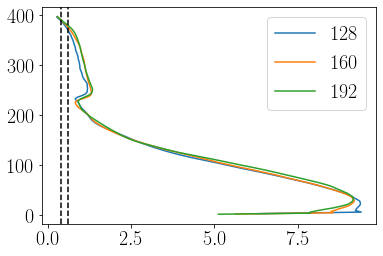

In [6]:
# plt.plot(s.xytavg["u"][1:-1], s.z[1:-1]/s.Ri["zB"])
for s in s_all:
    plt.plot(s.Ri["zB"], s.z[1:-1], label=s.lab)
plt.legend()
plt.axvline(0.4, linestyle="--", color="k")
plt.axvline(0.6, linestyle="--", color="k")
# s.z[1:-1]/s.Ri["zB"]
# plt.ylim([200, 200000])
# plt.yscale("log")

128: zLLJ = 157.48 m; zLLJ/zB = 67.35
     zB(z=zLLJ) = 2.34 m
160: zLLJ = 155.97 m; zLLJ/zB = 66.59
     zB(z=zLLJ) = 2.34 m
192: zLLJ = 154.97 m; zLLJ/zB = 65.55
     zB(z=zLLJ) = 2.36 m


(0, 500)

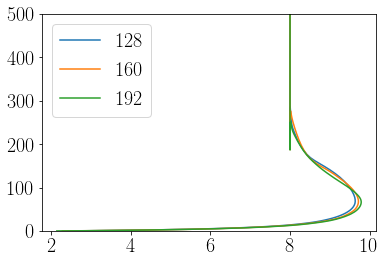

In [7]:
for s in s_all:
    plt.plot(s.xytavg["ws"][1:-1], s.z[1:-1]/s.Ri["zB"], label=s.lab)
    ii = np.argmax(s.xytavg["ws"][1:-1])
    print(f"{s.lab}: zLLJ = {s.z[1:-1][ii]:4.2f} m; zLLJ/zB = {s.z[1:-1][ii]/s.Ri['zB'][ii]:4.2f}")
    print(f"     zB(z=zLLJ) = {s.Ri['zB'][ii]:4.2f} m")
plt.legend()
plt.ylim([0, 500])

mean sig_w/ustar = 1.2589
mean sig_w/ustar = 1.2827
mean sig_w/ustar = 1.3045
Square root of 2 = 1.4142


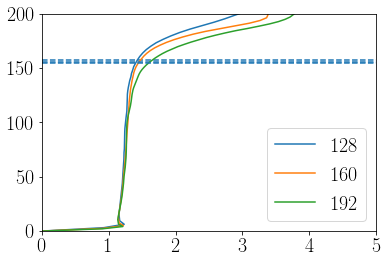

In [8]:
for s in s_all:
    v = (s.var["w_var_tot"]**0.5)/s.cov["ustar"]
    plt.plot(v, s.z, label=s.lab)
    ii = np.argmax(s.xytavg["ws"])
    jj = np.where(s.z >= 30.)[0][0]
    plt.axhline(s.z[ii], linestyle="--")
    print(f"mean sig_w/ustar = {np.mean(v[jj:ii]):5.4f}")
plt.legend()
plt.ylim([0, 200])
plt.xlim([0, 5])
print(f"Square root of 2 = {np.sqrt(2):5.4f}")

In [9]:
# average between s256a and s256b
# weighted average since a was averaged twice as long as b
for key in s256a.xytavg.keys():
    s256c.xytavg[key] = np.average(np.array([s256a.xytavg[key], s256b.xytavg[key]]), axis=0, weights=[2,1])
for key in s256a.cov.keys():
    s256c.cov[key] = np.average(np.array([s256a.cov[key], s256b.cov[key]]), axis=0, weights=[2,1])
for key in s256a.var.keys():
    s256c.var[key] = np.average(np.array([s256a.var[key], s256b.var[key]]), axis=0, weights=[2,1])
# tidy up s256
s256c.z = s256a.z
s256c.zi = 0.
# pop off 256a and 256b, add 256c to s_all
s_all.pop()
s_all.pop()
s_all.append(s256c)

NameError: name 's256c' is not defined

NameError: name 's_all' is not defined

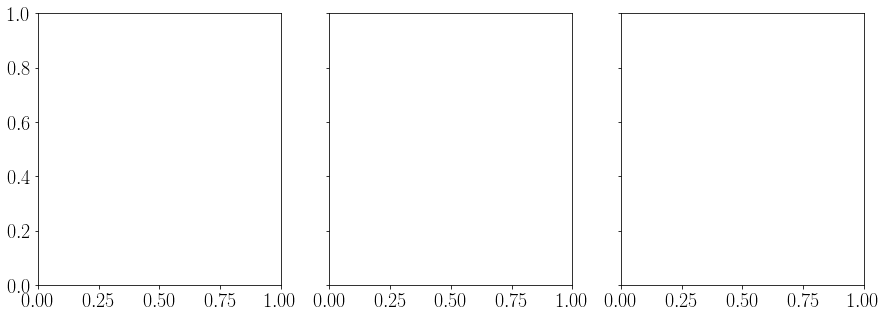

In [6]:
# plot mean u, v, theta versus z for each sim
fig1, ax1 = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(14.8, 5))
# lines = ["-", "--", ":", "-.", "-"]
# colors = ["k", "b", "r", "g", "c"]
colors = [(225./255, 156./255, 131./255),
          (134./255, 149./255, 68./255), (38./255, 131./255, 63./255),
          (0., 85./255, 80./255), (20./255, 33./255, 61./255), (252./255, 193./255, 219./255)]
for i, s in enumerate(s_all):
    # u
    ax1[0].plot(s.xytavg["u"], s.z, color=colors[i], linestyle="-", label=s.lab)
    # v
    ax1[0].plot(s.xytavg["v"], s.z, color=colors[i], linestyle=":")
    # ws
    ax1[1].plot(s.xytavg["ws"], s.z, color=colors[i], linestyle="-")
    # theta
    ax1[2].plot(s.xytavg["theta"], s.z, color=colors[i], linestyle="-")
    ax1[2].axhline(s.zi, color=colors[i], linestyle=":", linewidth=2, 
                   label=f"$z_i = {s.zi:4.1f}$ m")
# clean up
ax1[0].grid()
ax1[0].legend()
ax1[0].set_xlabel(r"$\langle u \rangle$, $\langle v \rangle$ [m s$^{-1}$]")
ax1[0].set_ylabel("$z$ [m]")

ax1[1].grid()
ax1[1].set_xlabel(r"Wind Speed [m s$^{-1}$]")

ax1[2].grid()
ax1[2].legend()
ax1[2].set_xlabel(r"$\langle \theta \rangle$ [K]")

# save figure
fdir_save = "/home/bgreene/Python/figures/random_errors/"
# fig1.savefig(f"{fdir_save}u_v_theta.pdf", format="pdf", bbox_inches="tight")

Text(0.5, 0, "$\\langle \\theta'w' \\rangle$ [K m s$^{-1}$]")

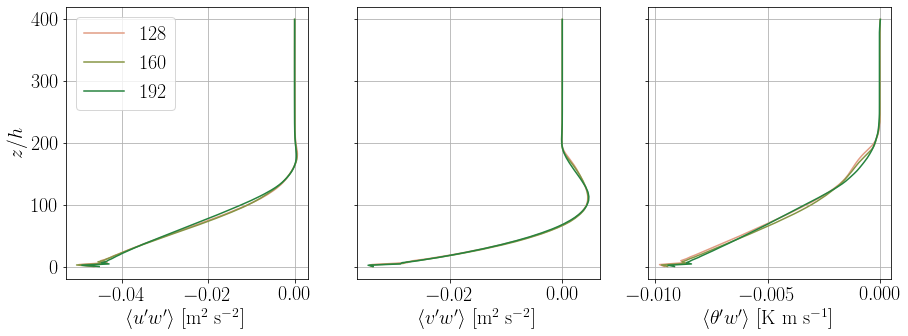

In [11]:
# plot u'w', v'w', theta'w'
fig2, ax2 = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(14.8, 5))
for i, s in enumerate(s_all):
    # u'w'
    ax2[0].plot(s.cov["uw_cov_tot"], s.z, color=colors[i], linestyle="-", label=str(s.nx).zfill(3))
#     ax2[0].plot(s.cov["uw_cov_res"], s.z, color="r", linestyle=lines[i])
    # v'w'
    ax2[1].plot(s.cov["vw_cov_tot"], s.z, color=colors[i], linestyle="-")
#     ax2[1].plot(s.cov["vw_cov_res"], s.z, color="r", linestyle=lines[i])
    # theta'w'
    ax2[2].plot(s.cov["thetaw_cov_tot"], s.z, color=colors[i], linestyle="-")
#     ax2[2].plot(s.cov["thetaw_cov_res"], s.z, color="r", linestyle=lines[i])
# clean up
ax2[0].grid()
ax2[0].legend()
ax2[0].set_xlabel(r"$\langle u'w' \rangle$ [m$^2$ s$^{-2}$]")
ax2[0].set_ylabel("$z/h$")
# ax2[0].set_ylim([-0.05, 1.])

ax2[1].grid()
ax2[1].set_xlabel(r"$\langle v'w' \rangle$ [m$^2$ s$^{-2}$]")

ax2[2].grid()
ax2[2].set_xlabel(r"$\langle \theta'w' \rangle$ [K m s$^{-1}$]")

# save figure
# fig2.savefig(f"{fdir_save}covars.pdf", format="pdf", bbox_inches="tight")

Text(0.5, 0, "$\\langle w'^2 \\rangle$ [m$^2$ s$^{-2}$]")

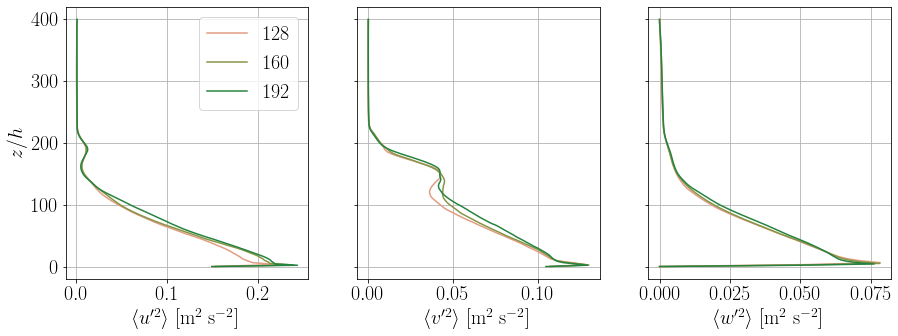

In [12]:
# plot u'u', v'v', w'w'
fig3, ax3 = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(14.8, 5))
for i, s in enumerate(s_all):
    # u'u'
    ax3[0].plot(s.var["u_var_tot"], s.z, color=colors[i], linestyle="-", label=str(s.nx).zfill(3))
    # v'v'
    ax3[1].plot(s.var["v_var_tot"], s.z, color=colors[i], linestyle="-")
    # theta'w'
    ax3[2].plot(s.var["w_var_tot"], s.z, color=colors[i], linestyle="-")
# clean up
ax3[0].grid()
ax3[0].legend()
ax3[0].set_xlabel(r"$\langle u'^2 \rangle$ [m$^2$ s$^{-2}$]")
ax3[0].set_ylabel("$z/h$")
# ax3[0].set_ylim([-0.05, 1.])

ax3[1].grid()
ax3[1].set_xlabel(r"$\langle v'^2 \rangle$ [m$^2$ s$^{-2}$]")

ax3[2].grid()
ax3[2].set_xlabel(r"$\langle w'^2 \rangle$ [m$^2$ s$^{-2}$]")

# save figure
# fig3.savefig(f"{fdir_save}vars.pdf", format="pdf", bbox_inches="tight")

Text(0.5, 0, '$u_{*}$ [m s$^{-1}$]')

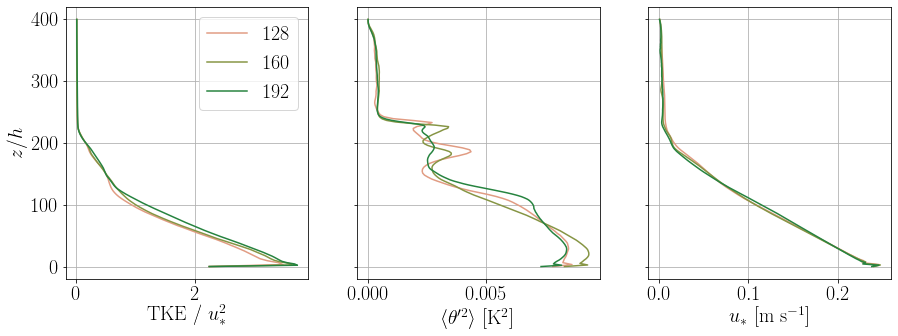

In [13]:
# plot TKE, theta var, ustar
fig4, ax4 = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(14.8, 5))
for i, s in enumerate(s_all):
    # TKE
    ax4[0].plot(s.var["TKE_tot"]/s.cov["ustar"][0]/s.cov["ustar"][0], s.z, color=colors[i], 
                linestyle="-", label=str(s.nx).zfill(3))
#     ax4[0].plot(s.var["TKE_sgs"]/s.cov["ustar"]/s.cov["ustar"], s.z, color=colors[i], 
#             linestyle=":")
    # theta var
    ax4[1].plot(s.var["theta_var_tot"], s.z, color=colors[i], linestyle="-")
    # ustar
    ax4[2].plot(s.cov["ustar"], s.z, color=colors[i], linestyle="-")
    
# clean up
ax4[0].grid()
ax4[0].legend()
ax4[0].set_xlabel(r"TKE / $u_{*}^2$")
ax4[0].set_ylabel("$z/h$")
# ax4[0].set_ylim([-0.05, 1.])

ax4[1].grid()
ax4[1].set_xlabel(r"$\langle \theta'^2 \rangle$ [K$^2$]")

ax4[2].grid()
ax4[2].set_xlabel(r"$u_{*}$ [m s$^{-1}$]")

# save figure
# fig4.savefig(f"{fdir_save}tke.pdf", format="pdf", bbox_inches="tight")

In [ ]:
# calculate turnover times
for s in s_all:
    Turn = 100./s.cov["ustar"][0] # use initial inversion height zi=100 m
    Turn2 = s.Ri["zB"][1]/s.cov["ustar"][2]
    print(f"Turnover time {s.nx:03d}: {Turn:5.2f} s")

(-0.1, 5)

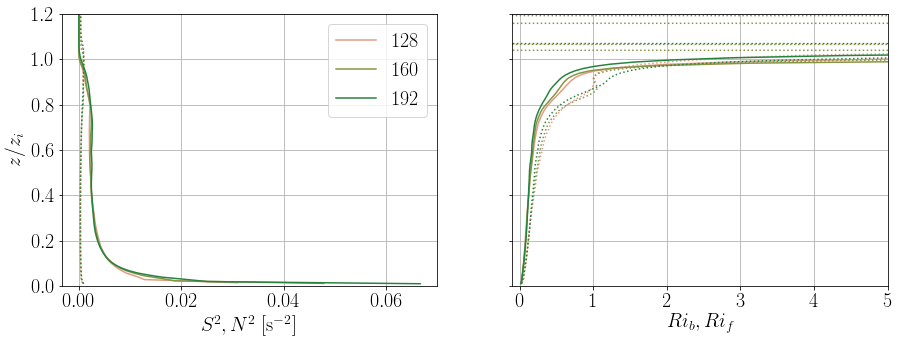

In [14]:
# plot S2 & N2, Ri
fig5, ax5 = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(14.8, 5))
for i, s in enumerate(s_all):
    # S2
    ax5[0].plot(s.Ri["S2"], s.z[1:-1]/s.zi, color=colors[i], linestyle="-", label=str(s.nx).zfill(3))
    # N2
    ax5[0].plot(s.Ri["N2"], s.z[1:-1]/s.zi, color=colors[i], linestyle=":")
    # Ri
    ax5[1].plot(s.Ri["Ri"], s.z[1:-1]/s.zi, color=colors[i], linestyle="-")
    # Ri_f
    ax5[1].plot(s.Ri["Ri_f"], s.z[1:-1]/s.zi, color=colors[i], linestyle=":")
# clean up
ax5[0].grid()
ax5[0].legend()
ax5[0].set_xlabel(r"$S^2, N^2$ [s$^{-2}$]")
ax5[0].set_ylabel("$z/z_i$")
ax5[0].set_ylim([0, 1.2])
# ax5[0].set_xscale("log")
# ax5[0].set_xlim([1e-4, 1e-1])

ax5[1].grid()
ax5[1].set_xlabel(r"$Ri_b, Ri_f$")
ax5[1].set_xlim([-0.1, 5])

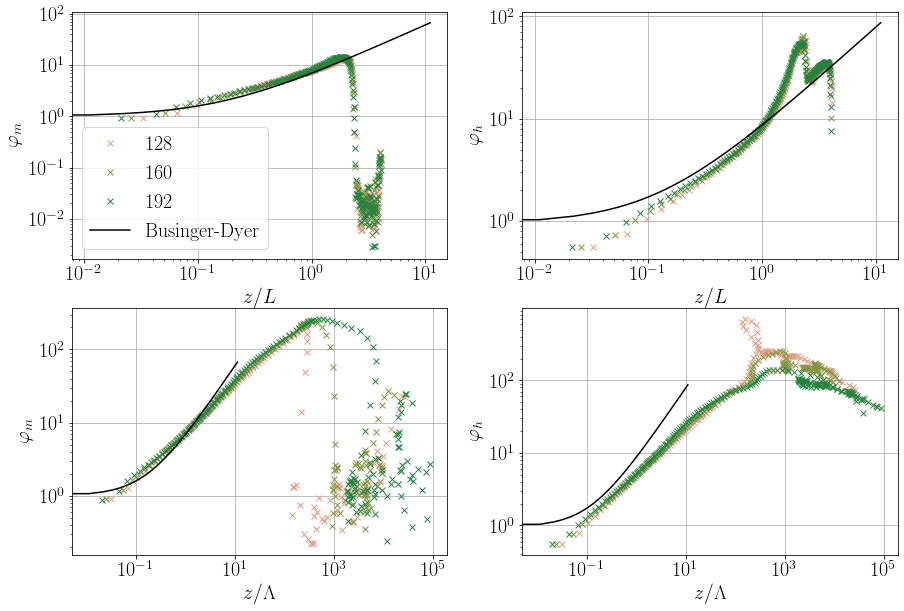

In [15]:
# plot MOST
fig6, ax6 = plt.subplots(nrows=2, ncols=2, figsize=(14.8, 10))
for i, s in enumerate(s_all):
    # phi_m vs z/L
    ax6[0,0].plot(s.z[1:-1]/s.cov["L"][0], s.most["phi_m"], markeredgecolor=colors[i], linestyle="",
                marker="x", label=str(s.nx).zfill(3))
    # phi_h vs z/L
    ax6[0,1].plot(s.z[1:-1]/s.cov["L"][0], s.most["phi_h"], markeredgecolor=colors[i], linestyle="",
                marker="x")
    # phi_m vs z/Lambda
    ax6[1,0].plot(s.z[1:-1]/s.cov["L"][1:-1], s.most["phi_m_l"], markeredgecolor=colors[i], linestyle="",
                marker="x", label=str(s.nx).zfill(3))
    # phi_h vs z/Lambda
    ax6[1,1].plot(s.z[1:-1]/s.cov["L"][1:-1], s.most["phi_h_l"], markeredgecolor=colors[i], linestyle="",
                marker="x")
    
# plot Businger-Dyer phim and phih
z_L = np.linspace(0., 11., 1000)
phi_m_BD = 1. + 6.*z_L
phi_h_BD = 0.95 + 7.8*z_L
ax6[0,0].plot(z_L, phi_m_BD, "-k", label="Businger-Dyer")
ax6[0,1].plot(z_L, phi_h_BD, "-k")
ax6[1,0].plot(z_L, phi_m_BD, "-k", label="Businger-Dyer")
ax6[1,1].plot(z_L, phi_h_BD, "-k")
    
# clean up
ax6[0,0].grid()
ax6[0,0].legend()
ax6[0,0].set_xlabel("$z/L$")
ax6[0,0].set_ylabel(r"$\varphi_m$")
ax6[0,0].set_xscale("log")
ax6[0,0].set_yscale("log")
# ax6[0].set_ylim([0, 1.2])

ax6[0,1].grid()
ax6[0,1].set_xlabel("$z/L$")
ax6[0,1].set_ylabel(r"$\varphi_h$")
ax6[0,1].set_xscale("log")
ax6[0,1].set_yscale("log")

ax6[1,0].grid()
ax6[1,0].set_xlabel("$z/\Lambda$")
ax6[1,0].set_ylabel(r"$\varphi_m$")
ax6[1,0].set_xscale("log")
ax6[1,0].set_yscale("log")
# ax6[0].set_ylim([0, 1.2])

ax6[1,1].grid()
ax6[1,1].set_xlabel("$z/\Lambda$")
ax6[1,1].set_ylabel(r"$\varphi_h$")
ax6[1,1].set_xscale("log")
ax6[1,1].set_yscale("log")

In [32]:
# print out lowest level value of Lambda
for s in s_all:
    print(s.nx)
    print(f"L* = {s.cov['L'][0]:5.2f} m")
    print(f"z/L* = {s.dz/s.cov['L'][0]:5.5f}")

96
L* = 21.97 m
z/L* = 0.19168
128
L* = 21.60 m
z/L* = 0.14584
160
L* = 21.18 m
z/L* = 0.11876
192
L* = 20.78 m
z/L* = 0.10078


(0.001, 10.0)

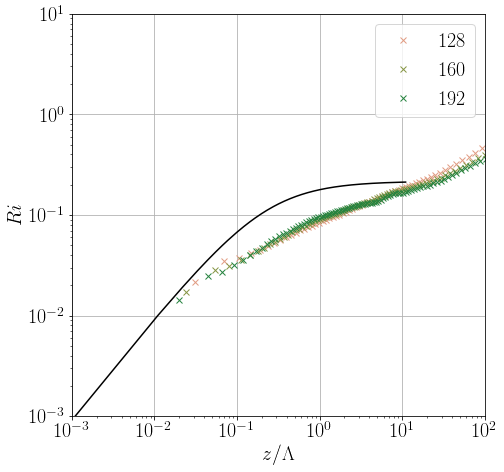

In [16]:
fig7, ax7 = plt.subplots(1, figsize=(7.4, 7.4))

for i, s in enumerate(s_all):
    ax7.plot(s.z[1:-1]/s.cov["L"][1:-1], s.Ri["Ri"], markeredgecolor=colors[i], linestyle="",
                    marker="x", label=str(s.nx).zfill(3))

Ri_most = z_L * phi_h_BD / (phi_m_BD**2.)
ax7.plot(z_L, Ri_most, "-k")

# clean up
ax7.grid()
ax7.legend()
ax7.set_xlabel(r"$z/\Lambda$")
ax7.set_ylabel("$Ri$")
ax7.set_xscale("log")
ax7.set_yscale("log")
ax7.set_xlim([1e-3, 1e2])
ax7.set_ylim([1e-3, 1e1])

(0.01, 10.0)

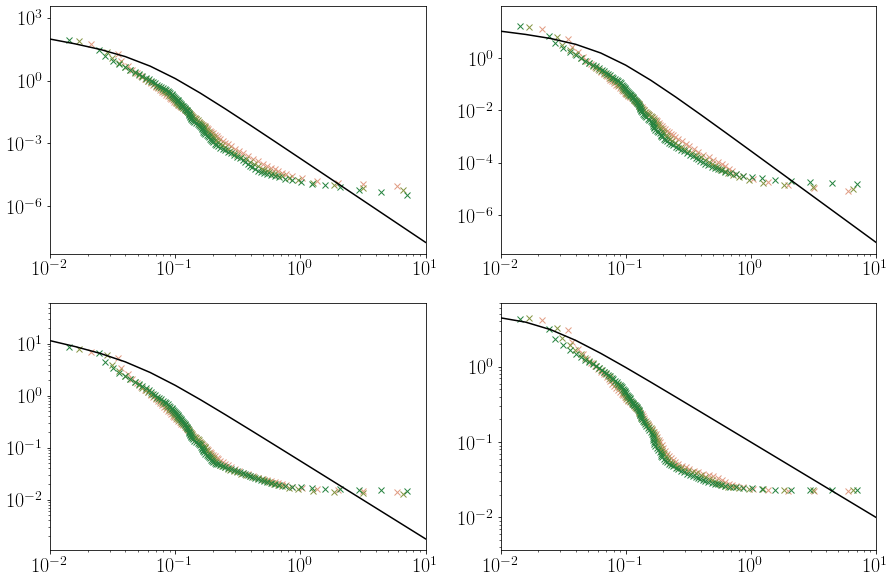

In [18]:
# plot gradient-based scaled turbulence
fig8, ax8 = plt.subplots(nrows=2, ncols=2, figsize=(14.8, 10))
# define Ri_bins to use as plotting empirical curves
n_bins = 21
Ri_bins_plot = np.logspace(-3, 1, num=n_bins)
# begin looping over all simulations
for i, s in enumerate(s_all):
    # Gm
    ax8[0,0].plot(s.Ri["Ri"], s.most["Gm"], marker="x", linestyle="", markeredgecolor=colors[i])
    # Gh
    ax8[0,1].plot(s.Ri["Ri"], s.most["Gh"], marker="x", linestyle="", markeredgecolor=colors[i])
    # Gw
    ax8[1,0].plot(s.Ri["Ri"], s.most["Gw"], marker="x", linestyle="", markeredgecolor=colors[i])
    # Gtheta
    ax8[1,1].plot(s.Ri["Ri"], s.most["Gtheta"], marker="x", linestyle="", markeredgecolor=colors[i])
    

# Gm
Gm_e = 1. / (Ri_bins_plot * ((1. + 300.*(Ri_bins_plot**2.))**1.5))
ax8[0,0].plot(Ri_bins_plot, Gm_e, linestyle="-", color="k")
ax8[0,0].set_xscale("log")
ax8[0,0].set_yscale("log")
ax8[0,0].set_xlim([1e-2, 1e1])
# ax8[0,0].set_ylim([1e3, 1e-2])

# Gh
Gh_e = 1. / (0.9 * (Ri_bins_plot**0.5) * ((1. + 250.*(Ri_bins_plot**2.))**1.5))
ax8[0,1].plot(Ri_bins_plot, Gh_e, linestyle='-', color='k')
ax8[0,1].set_xscale("log")
ax8[0,1].set_yscale("log")
ax8[0,1].set_xlim([1e-2, 1e1])
# ax8[0,0].set_ylim([1e3, 1e-2])

# Gw
Gw_e = 1. / (0.85*(Ri_bins_plot**0.5)*((1. + 450.*(Ri_bins_plot**2.))**0.5))
ax8[1,0].plot(Ri_bins_plot, Gw_e, linestyle='-', color='k')
ax8[1,0].set_xscale("log")
ax8[1,0].set_yscale("log")
ax8[1,0].set_xlim([1e-2, 1e1])
# ax8[0,0].set_ylim([1e3, 1e-2])

# Gm
Gtheta_e = 5. / ((1. + 2500.*(Ri_bins_plot**2.))**0.5)
ax8[1,1].plot(Ri_bins_plot, Gtheta_e, linestyle='-', color='k')
ax8[1,1].set_xscale("log")
ax8[1,1].set_yscale("log")
ax8[1,1].set_xlim([1e-2, 1e1])
# ax8[0,0].set_ylim([1e3, 1e-2])

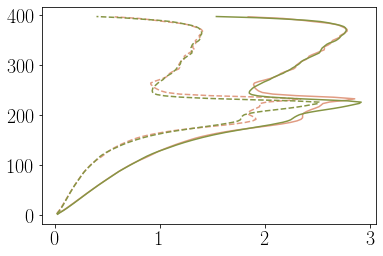

In [19]:
for i, s in enumerate(s_all[:-1]):
    plt.plot(s.most["Us"], s.z[1:-1], "-", color=colors[i])
    plt.plot(s.most["Ts"], s.z[1:-1], "--", color=colors[i])

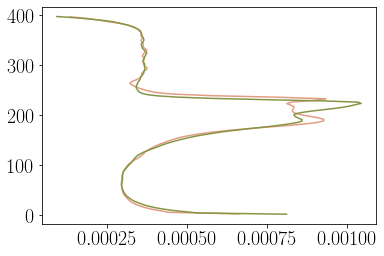

In [20]:
for i, s in enumerate(s_all[:-1]):
    plt.plot(s.Ri["N2"], s.z[1:-1], "-", color=colors[i])

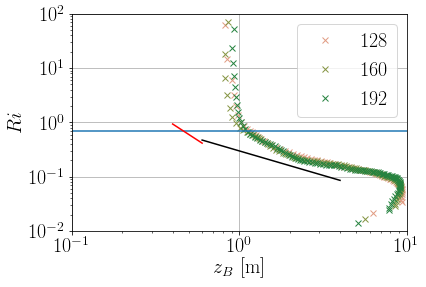

In [21]:
for i, s in enumerate(s_all):
    plt.plot(s.Ri["zB"], s.Ri["Ri"], marker="x", label=s.lab,
             markeredgecolor=colors[i], linestyle="")
plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.xlim([1e-1, 1e1])
plt.ylim([1e-2, 1e2])
plt.xlabel("$z_B$ [m]")
plt.ylabel("$Ri$")
plt.legend()
plt.axhline(0.7)

z_zB = np.linspace(1e0, 1e2, 1000)
Ri_zB = 0.1 * z_zB ** 0.3
# plt.plot(z_zB, Ri_zB, "-k")
zB_plot = np.linspace(0.6, 4)
Ri_zB = 0.3*zB_plot ** (-0.9)
plt.plot(zB_plot, Ri_zB, "-k")

zB_plot2 = np.linspace(0.4, 0.6)
Ri_zB2 = 0.15*zB_plot2 ** (-2.)
plt.plot(zB_plot2, Ri_zB2, "-r")

In [ ]:
s096.var["u_var_tot"] - s096.var["u_var_res"]

In [ ]:
s096.var["u_var_tot"]

In [ ]:
s.zi

In [ ]:
f = "/home/bgreene/simulations/C_128_interp/output/average_timeseries.csv"
dat = np.genfromtxt(f, delimiter=",", skip_header=1)

In [ ]:
plt.plot(dat[:,2]-dat[:,1], dat[:,0])
plt.plot(dat[:,2], dat[:,0])

# Look at check_ke.out for each simulation

In [ ]:
# grids = ["spinup", "128_interp", "160_interp", "192_interp", "256_interp"]
# lab = ["096", "128", "160", "192", "256"]
grids = ["spinup", "128_interp", "160_interp", "192_interp", "256_interp"]
lab = ["096", "128", "160", "192", "256"]
ke_dic = {}
for i, g in enumerate(grids):
    f_ke = f"/home/bgreene/simulations/F_{g}/output/check_ke.out"
    d_ke = np.genfromtxt(f_ke, dtype=float)
    ke_dic[g] = {}
    ke_dic[g]["t"] = d_ke[:, 0]
    ke_dic[g]["ke"] = d_ke[:, 1]
    ke_dic[g]["lab"] = lab[i]
    if i == 1:
        dt = 0.04 # seconds
    else:
        dt = 0.02 # seconds
        
    ke_dic[g]["t_hrs"] = ke_dic[g]["t"] * dt / 3600.

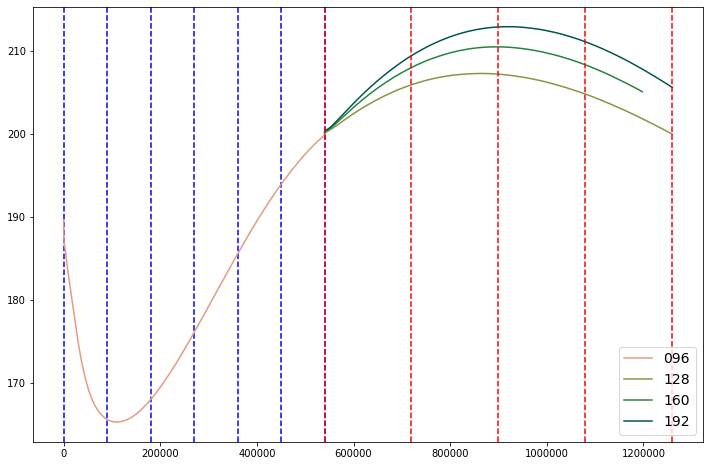

In [7]:
colors = [(225./255, 156./255, 131./255),
          (134./255, 149./255, 68./255), (38./255, 131./255, 63./255),
          (0., 85./255, 80./255), (20./255, 33./255, 61./255), (252./255, 193./255, 219./255)]
fig000, ax000 = plt.subplots(1, figsize=(12,8))
for i, g in enumerate(grids):
    ax000.plot(ke_dic[g]["t"], ke_dic[g]["ke"], c=colors[i], 
               label=ke_dic[g]["lab"])
for i in np.arange(540000, 1261000, 180000):
    ax000.axvline(i, c="r", linestyle="--")
for i in np.arange(0, 541000, 90000):
    ax000.axvline(i, c="b", linestyle="--", zorder=0)
ax000.legend(loc="lower right", fontsize=14)

In [14]:
np.arange(540000, 1261000, 180000)

array([ 540000,  720000,  900000, 1080000, 1260000])

# Look at the 96^3 long simulation

In [ ]:
flong = "/home/bgreene/simulations/C_096_long/"
f_ke = f"{flong}output/check_ke.out"
f_dis000 = f"{flong}output/Pr_timeseries_c000.out"
f_dis001 = f"{flong}output/Pr_timeseries_c001.out"
f_dis002 = f"{flong}output/Pr_timeseries_c002.out"
d_ke = np.genfromtxt(f_ke, dtype=float)
d_dis000 = np.genfromtxt(f_dis000, dtype=float)
d_dis001 = np.genfromtxt(f_dis001, dtype=float)
d_dis002 = np.genfromtxt(f_dis002, dtype=float)

In [ ]:
plt.plot(d_ke[:,1])
plt.xlabel("Timestep")
plt.ylabel("KE")

In [ ]:
plt.plot(d_ke[2000000:3100000,1])

In [ ]:
1./((3100000-2000000) * 0.04)

In [ ]:
plt.plot(d_dis000[10000:,1],label="L1")
plt.plot(d_dis001[10000:,1],label="L2")
plt.plot(d_dis002[10000:,1],label="L3")
plt.legend()

In [ ]:
d_dis048[:,1].mean()

# Timeseries data

In [ ]:
# 96 long - 2nd lowest gridpoint
f_u = f"{flong}output/u_timeseries_c001.out"
f_v = f"{flong}output/v_timeseries_c001.out"
f_w = f"{flong}output/w_timeseries_c001.out"
f_theta = f"{flong}output/t_timeseries_c001.out"
f_txz = f"{flong}output/txz_timeseries_c001.out"
f_tyz = f"{flong}output/tyz_timeseries_c001.out"
f_q3 = f"{flong}output/q3_timeseries_c001.out"

In [ ]:
# read each file
d_u = np.genfromtxt(f_u, dtype=float)
d_v = np.genfromtxt(f_v, dtype=float)
d_w = np.genfromtxt(f_w, dtype=float)
d_theta = np.genfromtxt(f_theta, dtype=float)
d_txz = np.genfromtxt(f_txz, dtype=float)
d_tyz = np.genfromtxt(f_tyz, dtype=float)
d_q3 = np.genfromtxt(f_q3, dtype=float)

In [ ]:
len(d_u), len(d_tyz)

In [ ]:
2090 * 1500

In [ ]:
# only grab first 1200000 points from each and apply scales
# iend = 3135000
d_u = d_u[:, 1] * 0.4
d_v = d_v[:, 1] * 0.4
d_w = d_w[:, 1] * 0.4
d_theta = d_theta[:, 1] * 300.
d_txz = d_txz[:, 1] * 0.4 * 0.4
d_tyz = d_tyz[:, 1] * 0.4 * 0.4
d_q3 = d_q3[:, 1] * 0.4 * 300.

In [ ]:
def cov(x, y, sgs, nt_mean):
    i0 = 0
    i1 = i0 + nt_mean
    xy_cov = []
    nmean = int(len(x)/nt_mean)
    for i in range(nmean):
        x_mean = np.mean(x[i0:i1])
        y_mean = np.mean(y[i0:i1])
        x_pert = x[i0:i1] - x_mean
        y_pert = y[i0:i1] - y_mean
        xy_pert = x_pert * y_pert
        xy_cov.append(np.mean(xy_pert)+np.mean(sgs[i0:i1]))
        i0 = i1
        i1 += nt_mean
    return np.array(xy_cov)
    

In [ ]:
9000 * 0.04 / 60

In [ ]:
uw_cov_tot = cov(d_u, d_w, d_txz, 9000)
vw_cov_tot = cov(d_v, d_w, d_tyz, 9000)
thetaw_cov_tot = cov(d_theta, d_w, d_q3, 9000)

In [ ]:
ustar = (uw_cov_tot ** 2. + vw_cov_tot ** 2.) ** 0.5

In [ ]:
plt.plot(ustar)
plt.xlabel("Time (min)")
plt.ylabel("ustar (m/s)")

In [ ]:
plt.plot(thetaw_cov_tot)
plt.xlabel("Time (min)")
plt.ylabel("H (K m/s)")

In [ ]:
# sbl_h_timeseries data
fh = f"{flong}output/sbl_h_timeseries.csv"
dh = np.genfromtxt(fh, skip_header=1, dtype=float, delimiter=",")

In [ ]:
(3240000/len(dh)) * 0.04

In [ ]:
plt.plot(dh[:,0], dh[:,1])
plt.xlabel("Time (min)")
plt.ylabel("h (m)")

In [ ]:
t = np.linspace(0., 10., 10001)
x = np.sin(2.*np.pi*t/5)
dxdt_ex = np.cos(2.*np.pi*t/5)
plt.plot(t,x)

fk = np.fft.fft(x)
freqz = np.fft.fftfreq(len(x), d=np.diff(t)[0])
dxdt = np.fft.ifft(1j*freqz*fk)

plt.plot(t, dxdt)
plt.plot(t, dxdt_ex)

In [ ]:
x[499:502]

In [ ]:
dxdt[499:502]

In [ ]:
dxdt_ex[499:502]

In [ ]:
dxdt[500].real/dxdt_ex[500]

# Look at dissipation volumes

In [ ]:
def read_f90_bin(path,nx,ny,nz,precision):  
    f=open(path,'rb')
    if (precision==4):
        dat=np.fromfile(f,dtype='float32',count=nx*ny*nz)
    elif (precision==8):
        dat=np.fromfile(f,dtype='float64',count=nx*ny*nz)
    else:
        raise ValueError('Precision must be 4 or 8')
    dat=np.reshape(dat,(nx,ny,nz),order='F')
    f.close()
    return dat

In [ ]:
fo = "/home/bgreene/simulations/C_096_dissip/"
fd = f"{fo}output/dissip_0900000.out"
ft = f"{fo}output/Pr_timeseries_c095.out"

In [ ]:
# dis_vo = read_f90_bin(fd, 96,96,96,8)
dis_ts = np.genfromtxt(ft, dtype=float)

In [ ]:
plt.plot(dis_ts[10000:,1])

In [ ]:
dis_ts[810000:,1].mean() * 0.4*0.4*0.4/400.

In [ ]:
plt.plot(np.mean(dis_vo, axis=(0,1)), np.linspace(0., 400., 96))

In [ ]:
dis_ts[-1,1]

In [ ]:
np.mean(dis_vo, axis=(0,1))[0:2]

# Load average statistics file to compare with timeseries averages

In [ ]:
fo = "/home/bgreene/simulations/A_160_interp/"
ff = f"{fo}output/average_statistics.csv"
dd = np.genfromtxt(ff, dtype=float, delimiter=",", skip_header=1)
dissip = dd[:,5]
z = dd[:,0]

In [ ]:
plt.plot(dissip,z)

In [ ]:
dissip_ts = np.zeros(96, dtype=float)
for iz in range(96):
    ft = f"{fo}output/Pr_timeseries_c{iz:03d}.out"
    print(ft)
    dis_ts = np.genfromtxt(ft, dtype=float)
    dissip_ts[iz] = np.mean(dis_ts[811000:,1]) * 0.4*0.4*0.4/400.

In [ ]:
plt.plot(dissip_ts, z, label="Timeseries Pr")
plt.plot(-dissip,z, label="xyt-avg Volumes")
plt.xlabel("Dissipation Rate [m2 s-3]")
plt.ylabel("z [m]")
plt.legend(loc="upper right")
plt.grid()

# Read the TKE budget term output

In [ ]:
ftke = f"{fo}output/tke_budget.csv"
dtke = np.genfromtxt(ftke, dtype=float, skip_header=1, delimiter=",")
z = dtke[:,0]
shear = dtke[:,1]
buoy = dtke[:,2]
trans = dtke[:,3]
diss = dtke[:,4]
tot = np.sum(dtke[:,1:], axis=1)
residual = np.zeros(len(z)) - tot

In [ ]:
# load in the mean statistics to get sbl scales: ustar0=ustar(iz=0) and zj=height of LLJ
ff = f"{fo}output/average_statistics.csv"
dd = np.genfromtxt(ff, dtype=float, delimiter=",", skip_header=1)

ustar = ((dd[:,7]**2.) + (dd[:,9]**2.)) ** 0.25
ustar0 = ustar[0]

ws = ((dd[:,1]**2.) + (dd[:,2]**2.)) ** 0.5
izj = np.argmax(ws)
zj = dd[izj,0]

# calculate scale: ustar^3 / zj
# calculate scale: ustar0^3 / kappa / z
sscale = (ustar0**3.) / z[1:] / 0.4

In [ ]:
zj

In [ ]:
fig10, ax10 = plt.subplots(1, figsize=(12,8))

ax10.plot(shear[1:]/sscale, z[1:], label="Shear Production")
ax10.plot(buoy[1:]/sscale, z[1:], label="Buoyancy Production")
ax10.plot(trans[1:]/sscale, z[1:], label="Turbulent Transport")
ax10.plot(diss[1:]/sscale, z[1:], label="3D Dissipation")
ax10.plot(residual[1:]/sscale, z[1:], label="Residual")
ax10.axhline(zj, color="k", linestyle="--", label="LLJ")
ax10.grid()
ax10.legend(loc="upper right")
ax10.set_xlabel("Dimensionless TKE Budget Terms [-]")
ax10.set_ylabel("z [m]")
ax10.set_title("TKE Budget (z-direction)")
ax10.set_ylim([0., 200.])
ax10.set_xlim([-5., 5.])

# save figure
# fig10.savefig(f"{fdir_save}tke_budget.pdf", format="pdf", bbox_inches="tight")

In [ ]:
ustar

In [ ]:
plt.plot(ustar, z)

# Look at Ozmidov length scale Lo

### $L_o = \sqrt{ \langle \epsilon \rangle / \langle N^2 \rangle ^{3/2} }$

In [ ]:
theta = dd[:, 4]
dtheta_dz = []
dz = np.diff(dd[:,0])[0]

for i in range(1, len(z)-1):
    dtheta_dz.append( (theta[i+1] - theta[i-1]) / (2.*dz) )
dtheta_dz = np.array(dtheta_dz)

N2 = dtheta_dz * 9.81 / theta[0]
Lo = np.sqrt(-diss[1:-1] / (N2 ** (3./2.)))

Text(0.5, 0, '$L_o = \\sqrt{ \\langle \\epsilon \\rangle / \\langle N^2 \\rangle ^{3/2} }$ [m]')

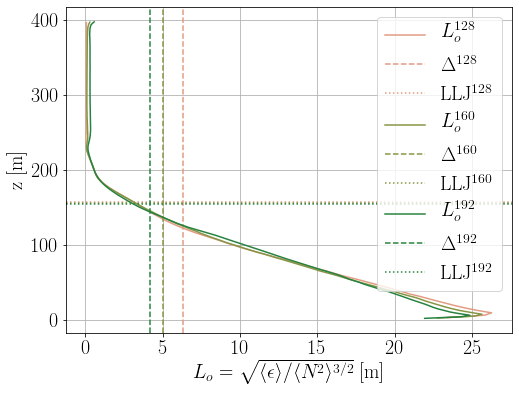

In [24]:
fig11, ax11 = plt.subplots(1, figsize=(8, 6))
for i, s in enumerate(s_all):
    ax11.plot(s.Ri["Lo"], s.z[1:-1], "-", label=f"$L_o^{{{s.nx}}}$", c=colors[i])
    ax11.axvline(800./(s.nx-1.), linestyle="--", color=colors[i], label=f"$\Delta^{{{s.nx}}}$")
    ax11.axhline(s.xytavg["zj"], linestyle=":", color=colors[i], label=f"LLJ$^{{{s.nx}}}$")
ax11.grid()
ax11.legend()
ax11.set_ylabel("z [m]")
ax11.set_xlabel(r"$L_o = \sqrt{ \langle \epsilon \rangle / \langle N^2 \rangle ^{3/2} }$ [m]")

# save figure
# fig11.savefig(f"{fdir_save}Lo.pdf", format="pdf", bbox_inches="tight")

In [ ]:
800./(np.array([96., 128., 160., 192., 256.]) - 1.)

# Plot initial profiles from C_spinup

In [ ]:
finit = "/home/bgreene/simulations/C_spinup/output/init_profiles.dat"
dinit = np.genfromtxt(finit)

In [ ]:
dinit.shape

In [ ]:
dinit[0]

In [ ]:
zinit = dinit[:96,6] * 400.
uinit = dinit[:96,7]
vinit = dinit[:96,8]
winit = dinit[:96,9]
Tinit = dinit[:96,10]

In [ ]:
fig12, ax12 = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(7.4, 5))
# u, v, w
ax12[0].plot(uinit, zinit, "-k", label="$u$")
ax12[0].plot(vinit, zinit, "-r", label="$v$")
ax12[0].plot(winit, zinit, "-b", label="$w$")
# format
ax12[0].grid()
ax12[0].legend(loc="upper center")
ax12[0].set_xlabel("$\langle u \\rangle, \langle v \\rangle, \langle w \\rangle$ [m s$^{-1}$]")
ax12[0].set_ylabel("$z$ [m]")
ax12[0].xaxis.set_major_locator(MultipleLocator(2))
ax12[0].xaxis.set_minor_locator(MultipleLocator(0.5))
# theta
ax12[1].plot(Tinit, zinit, "-k", label="$v$")
ax12[1].grid()
ax12[1].set_xlabel("$\langle \\theta \\rangle$ [K]")
ax12[1].xaxis.set_major_locator(MultipleLocator(1))
ax12[1].xaxis.set_minor_locator(MultipleLocator(0.5))

# save figure
fig12.savefig(f"{fdir_save}init.pdf", format="pdf", bbox_inches="tight")

In [ ]:
len(Tinit)